<a href="https://colab.research.google.com/github/ikanx101/209_ITB/blob/main/Praktikum_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __PRAKTIKUM PENAMBANGAN DATA DALAM SAINS__
## Praktikum II: _Machine Learning_

Oleh: Mohammad Rizka Fadhli - 20921004

---

## ___Supervised Learning___

Pada praktikum ini, saya akan membuat model _predictive_ yang akan mengklasifikasikan variabel `failure_type` dari beberapa _predictors_ di data `predictive maintenance.csv`.

Akan ada tiga model yang dibuat, yakni:

1. Naive Bayes,
1. Decision Tree,
1. KNN,
1. ANN.

Ketiga model tersebut akan dibandingkan mana yang lebih baik dengan cara melihat _confusion matrix_-nya.

## __Tahapan Pengerjaan__

Berikut adalah tahapan yang akan saya kerjakan:

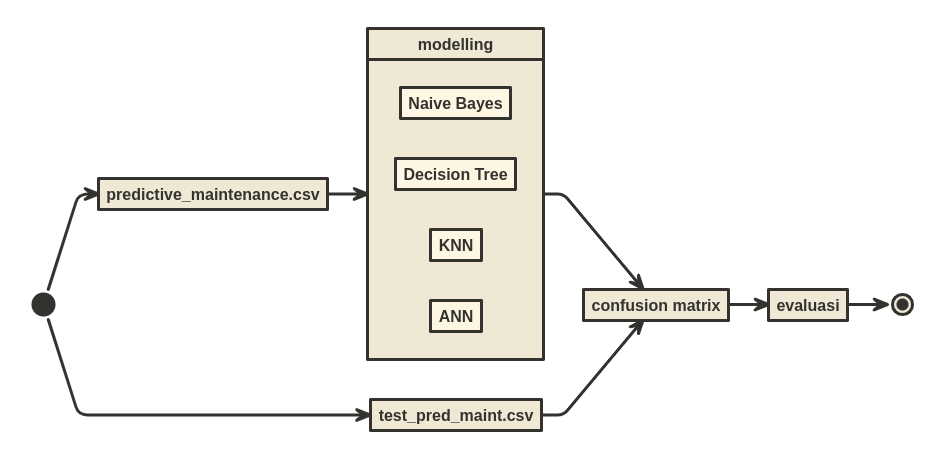


<br>

Proses _import_ _train dataset_ dan _test dataset_ saya lakukan langsung dari _link github_.

---

#### __Catatan Terkait Pengerjaan Praktikum__

Saya menggunakan bahasa __R__ untuk menyelesaikan tugas praktikum ini pada _environment_ [Google Colab](http://colab.to/r).

Untuk _data carpentry_ saya menggunakan prinsip _tidy_ dengan operator _pipe_ `%>%`.

In [275]:
# proses instalasi libraries yang dibutuhkan
#install.packages("janitor")     # untuk merapikan nama variabel
#install.packages("caret")       # untuk membuat confusion matriks dan decision tree
#install.packages("e1071")       # untuk naive bayes
#install.packages("tensorflow")  # untuk ANN
#install.packages("keras")       # untuk ANN

In [276]:
# memanggil semua libraries yang dibutuhkan
library(dplyr)
library(caret)
library(janitor)
library(e1071)
library(tensorflow)
library(keras)
library(ggplot2)
library(tidyr)

# membersihkan global environment
rm(list=ls())

# set seed agar reproducible
set.seed(20921004)

In [277]:
# proses import train dataset dan test dataset
train_ = read.csv("https://raw.githubusercontent.com/salmanhiro/Praktikum-Data-Mining/main/Praktikum%202/predictive_maintenance.csv") %>% janitor::clean_names()
test_ = read.csv("https://raw.githubusercontent.com/salmanhiro/Praktikum-Data-Mining/main/Praktikum%202/test_pred_maint.csv") %>% janitor::clean_names()

# melihat struktur data train
str(train_)

# melihat struktur data test
str(test_)

'data.frame':	8000 obs. of  11 variables:
 $ x                    : int  3926 5433 9989 341 9495 6842 140 9599 4590 9151 ...
 $ udi                  : int  3927 5434 9990 342 9496 6843 141 9600 4591 9152 ...
 $ product_id           : chr  "L51106" "L52613" "M24849" "M15201" ...
 $ type                 : chr  "L" "L" "M" "M" ...
 $ air_temperature_k    : num  303 303 299 297 299 ...
 $ process_temperature_k: num  312 312 308 308 310 ...
 $ rotational_speed_rpm : int  1609 1550 1577 1530 1373 1635 1511 1463 1456 1553 ...
 $ torque_nm            : num  36 45.5 33.2 32.6 44.8 29.6 36.1 37.4 36.1 40.5 ...
 $ tool_wear_min        : int  162 72 0 22 221 211 157 56 89 135 ...
 $ target               : int  0 0 0 0 0 0 0 0 0 0 ...
 $ failure_type         : chr  "No Failure" "No Failure" "No Failure" "No Failure" ...
'data.frame':	2000 obs. of  11 variables:
 $ x                    : int  3880 9631 6915 6852 8594 6171 8312 4527 3570 5933 ...
 $ udi                  : int  3881 9632 6916 6853 859

#### __Temuan dari Struktur Data Di Atas__

Dapat dilihat bahwa tidak semua variabel (atribut) bisa dijadikan _predictors_. Beberapa variabel seperti:

1. `x`
1. `udi`
1. `product_id`

akan saya hapus. 

Sedangkan variabel `type` akan saya lakukan _one hot encoding_ terlebih dahulu.

In [278]:
# pre processing

## simpan variabel target dan hapus variabel yang tidak perlu
### train
train_target = train_$failure_type
train_ = train_ %>% select(-x,-udi,-product_id,-failure_type)
### test
test_target = test_$failure_type
test_ = test_ %>% select(-x,-udi,-product_id,-failure_type)

## one hot encoding
### train
dummy_train = dummyVars("~.", data = train_)
train_clean = data.frame(predict(dummy_train, newdata = train_))
train_clean$failure_type = train_target # mengembalikan variabel target ke dalam train dataset

# kita akan pecah train menjadi dua:
  # 1. train clean
  # 1. validation_clean
  n_id_train = nrow(train_clean) * 80/100     # digunakan proporsi: 80 - 20
  id_train = sample(nrow(train_clean),
                         n_id_train,
                         replace = F)
  validation_clean = train_clean[-id_train,]
  train_clean = train_clean[id_train,]

  # khusus validation, saya akan ambil kembali failure_type dari dataset
  validation_target = validation_clean$failure_type
  validation_clean = validation_clean %>% select(-failure_type)
    
### test
dummy_test = dummyVars("~.", data = test_)
test_clean = data.frame(predict(dummy_test, newdata = test_))

Mari kita lihat hasilnya berikut:

In [279]:
# sample 10 data teratas dari train_clean dataset
train_clean %>% head(10)

,typeH,typeL,typeM,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,target,failure_type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
7903,0,1,0,301.7,310.8,1493,47.6,145,0,No Failure
5455,1,0,0,300.5,310.7,1654,28.6,161,0,No Failure
1227,0,1,0,299.8,309.4,1555,34.8,122,0,No Failure
6383,0,1,0,300.9,312.0,1441,43.8,210,0,No Failure
193,0,1,0,297.7,308.8,1354,50.2,103,0,No Failure
351,0,1,0,300.3,311.1,1606,30.9,156,0,No Failure
1759,0,1,0,297.2,308.6,1636,31.3,192,0,No Failure
5732,1,0,0,298.8,309.6,1309,57.4,185,0,No Failure
4989,0,1,0,298.1,308.6,1527,40.2,16,0,No Failure


---

# __NAIVE BAYES__

Pada _section_ ini, saya akan membuat model _Naive Bayes_.

Kemudian saya akan membuat _confusion matrix_ dari `validation_clean ` dan `test_clean` kemudian membandingkan hasil prediksi dengan variabel _target_ `test` sebenarnya.

In [280]:
# membuat model naive bayes
model_nb = naiveBayes(failure_type ~ ., data = train_clean)

# membuat prediksi dari validation_clean
pred_nb_val = predict(model_nb,newdata = validation_clean, type = "class") %>% as.character()

# membuat confusion matrix
table(validation_target,pred_nb_val)

# menghitung akurasi
akurasi_nb_val = mean(validation_target == pred_nb_val)
print(paste0("Akurasi: ",akurasi_nb_val))

                          pred_nb_val
validation_target          Heat Dissipation Failure No Failure
  Heat Dissipation Failure                       13          0
  No Failure                                      1       1508
  Overstrain Failure                              0          0
  Power Failure                                   2          0
  Random Failures                                 0          3
  Tool Wear Failure                               0          0
                          pred_nb_val
validation_target          Overstrain Failure Power Failure Random Failures
  Heat Dissipation Failure                  2             0               0
  No Failure                                0             4              41
  Overstrain Failure                        9             0               0
  Power Failure                             1            11               0
  Random Failures                           0             0               0
  Tool Wear Failure        

[1] "Akurasi: 0.965625"


In [281]:
# membuat prediksi dari test_clean
pred_nb = predict(model_nb,newdata = test_clean, type = "class") %>% as.character()

# membuat confusion matrix
table(test_target,pred_nb)

# menghitung akurasi
akurasi_nb = mean(test_target == pred_nb)
print(paste0("Akurasi: ",akurasi_nb))

                          pred_nb
test_target                Heat Dissipation Failure No Failure
  Heat Dissipation Failure                       23          0
  No Failure                                      0       1884
  Overstrain Failure                              0          0
  Power Failure                                   2          0
  Random Failures                                 0          5
  Tool Wear Failure                               0          0
                          pred_nb
test_target                Overstrain Failure Power Failure Random Failures
  Heat Dissipation Failure                  3             1               0
  No Failure                                0             5              50
  Overstrain Failure                        9             0               0
  Power Failure                             1            11               0
  Random Failures                           0             0               0
  Tool Wear Failure                

[1] "Akurasi: 0.9655"


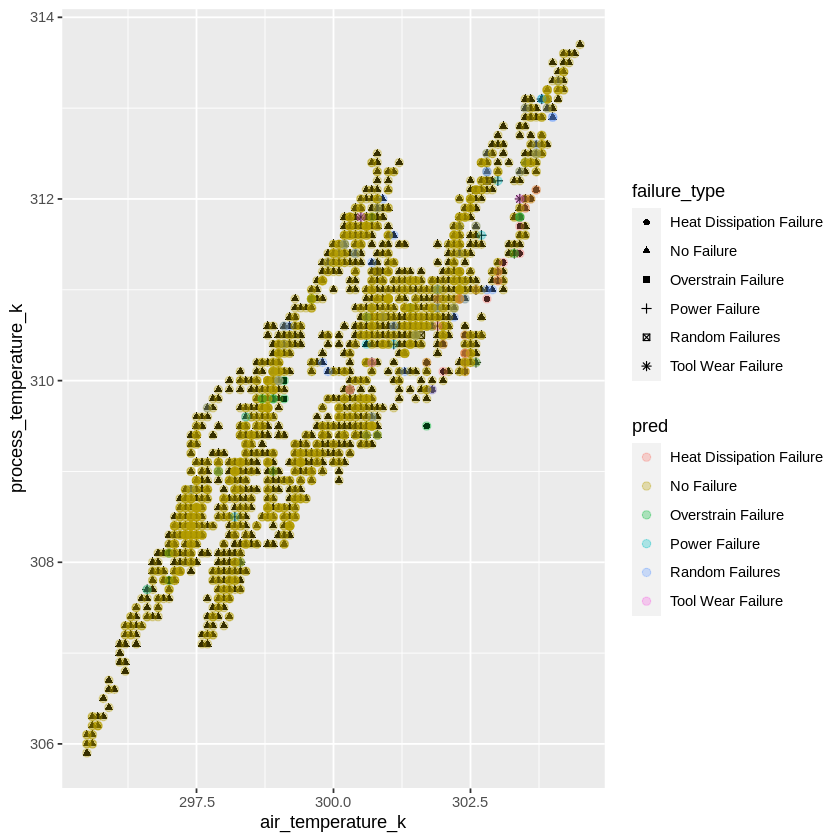

In [282]:
# Berikut adalah grafik perbandingan target real vs prediksi dari Naive Bayes
test_clean %>%
  mutate(failure_type = test_target,
         pred = pred_nb) %>%
  ggplot(aes(x = air_temperature_k,
             y = process_temperature_k)) +
  geom_point(aes(shape = failure_type)) +
  geom_point(aes(color = pred),
             size = 2,
             alpha = .3)

### __Kesimpulan__

Model _Naive Bayes_ menghasilkan akurasi sebesar `0.9655`

---

# __DECISION TREE__

Pada _section_ ini, saya akan membuat model _Decision Tree_.

Kemudian saya akan membuat _confusion matrix_ dari `validation_clean` dan `test_clean` kemudian membandingkan hasil prediksi dengan variabel _target_ `test` sebenarnya.

In [283]:
# membuat model decision tree
model_dt = caret::train(factor(failure_type) ~ ., data = train_clean, method="rpart")

# membuat prediksi dari validation_clean
pred_dt_val = predict(model_dt,newdata = validation_clean) %>% as.character()

# membuat confusion matrix
table(validation_target,pred_dt_val)

# menghitung akurasi
akurasi_dt_val = mean(validation_target == pred_dt_val)
print(paste0("Akurasi: ",akurasi_dt_val))

                          pred_dt_val
validation_target          Heat Dissipation Failure No Failure
  Heat Dissipation Failure                       13          0
  No Failure                                      2       1552
  Overstrain Failure                              0          0
  Power Failure                                  12          0
  Random Failures                                 0          3
  Tool Wear Failure                               0          0
                          pred_dt_val
validation_target          Overstrain Failure
  Heat Dissipation Failure                  2
  No Failure                                0
  Overstrain Failure                       10
  Power Failure                             2
  Random Failures                           0
  Tool Wear Failure                         4

[1] "Akurasi: 0.984375"


In [284]:
# membuat prediksi dari test_clean
pred_dt = predict(model_dt,newdata = test_clean) %>% as.character()

# membuat confusion matrix
table(test_target,pred_dt)

# menghitung akurasi
akurasi_dt = mean(test_target == pred_dt)
print(paste0("Akurasi: ",akurasi_dt))

                          pred_dt
test_target                Heat Dissipation Failure No Failure
  Heat Dissipation Failure                       21          0
  No Failure                                      2       1937
  Overstrain Failure                              0          0
  Power Failure                                  13          0
  Random Failures                                 0          5
  Tool Wear Failure                               0          0
                          pred_dt
test_target                Overstrain Failure
  Heat Dissipation Failure                  6
  No Failure                                0
  Overstrain Failure                        9
  Power Failure                             2
  Random Failures                           0
  Tool Wear Failure                         5

[1] "Akurasi: 0.9835"


### __Kesimpulan__

Model _Decision Tree_ menghasilkan akurasi sebesar `0.9835`

---

# __K-Nearest Neighbours__

Pada _section_ ini, saya akan membuat model _KNN_.

Kemudian saya akan membuat _confusion matrix_ dari `validation_clean` dan `test_clean` kemudian membandingkan hasil prediksi dengan variabel _target_ `test` sebenarnya.

In [285]:
# membuat model KNN
model_knn = caret::train(factor(failure_type) ~ ., data = train_clean, method="knn")

# membuat prediksi dari validation_clean
pred_knn_val = predict(model_knn,newdata = validation_clean) %>% as.character()

# membuat confusion matrix
table(validation_target,pred_knn_val)

# menghitung akurasi
akurasi_knn_val = mean(validation_target == pred_knn_val)
print(paste0("Akurasi: ",akurasi_knn_val))

                          pred_knn_val
validation_target          No Failure Overstrain Failure Power Failure
  Heat Dissipation Failure         15                  0             0
  No Failure                     1552                  1             1
  Overstrain Failure                6                  4             0
  Power Failure                    11                  1             2
  Random Failures                   3                  0             0
  Tool Wear Failure                 4                  0             0

[1] "Akurasi: 0.97375"


In [286]:
# membuat prediksi dari test_clean
pred_knn = predict(model_knn,newdata = test_clean) %>% as.character()

# membuat confusion matrix
table(test_target,pred_knn)

# menghitung akurasi
akurasi_knn = mean(test_target == pred_knn)
print(paste0("Akurasi: ",akurasi_knn))

                          pred_knn
test_target                No Failure Overstrain Failure Power Failure
  Heat Dissipation Failure         27                  0             0
  No Failure                     1935                  2             2
  Overstrain Failure                6                  3             0
  Power Failure                     8                  1             6
  Random Failures                   5                  0             0
  Tool Wear Failure                 5                  0             0

[1] "Akurasi: 0.972"


### __Kesimpulan__

Model _KNN_ menghasilkan akurasi sebesar `0.972`

---

# __Artificial Neural Network__

Pada _section_ ini, saya akan membuat model _ANN_ dengan berbagai nilai _epoch_ sebagai perbandingan.

Untuk memudahkan, saya akan menggunakan banyak _layer_, _nodes_, dan _activation function_ yang sama. Pada praktikum ini, saya menggunakan:

1. _Input layer_: 4 _nodes_
1. _Hidden layer_: 5 _nodes_
1. _Output layer_: 7 _nodes_

Kemudian saya akan membuat _confusion matrix_ dari `test_clean` kemudian membandingkan hasil prediksi dengan variabel _target_ `test` sebenarnya.

In [287]:
# preprocessing untuk keras dan tensorflow
  # untuk membuat ANN, saya menggunakan framework keras dan tensorflow
  # oleh karena itu, dibutuhkan input berupa matriks
  # train_clean dan validation_clean akan saya gabung karena nanti proses validasi akan dilakukan langsung
  validation_clean$failure_type = validation_target
  train_clean = rbind(train_clean,validation_clean)

In [288]:
# kita ubah dulu menjadi matrix
train_DL = train_clean %>% select(-failure_type) %>% as.matrix()
target_train_DL = train_clean$failure_type %>% as.factor() %>% as.numeric() %>% to_categorical()

In [289]:
# membuat model deep learning
model = keras_model_sequential()
model %>%
  layer_dense(units = 4,activation = 'sigmoid',input_shape = c(ncol(train_DL))) %>%
  layer_dense(units = 5, activation = 'sigmoid') %>%
  layer_dense(units = 7, activation = 'sigmoid')
summary(model)

# compile
model %>% compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=c('accuracy')
)

Model: "sequential_20"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_70 (Dense)                   (None, 4)                       40          
                                                                                
 dense_69 (Dense)                   (None, 5)                       25          
                                                                                
 dense_68 (Dense)                   (None, 7)                       42          
                                                                                
Total params: 107
Trainable params: 107
Non-trainable params: 0
________________________________________________________________________________


## Epoch = 10

Berikut adalah hasil perhitungan untuk epoch = 10

`geom_smooth()` using formula 'y ~ x'



                          
                           No Failure
  Heat Dissipation Failure         27
  No Failure                     1939
  Overstrain Failure                9
  Power Failure                    15
  Random Failures                   5
  Tool Wear Failure                 5

[1] "Akurasi = 0.9695"


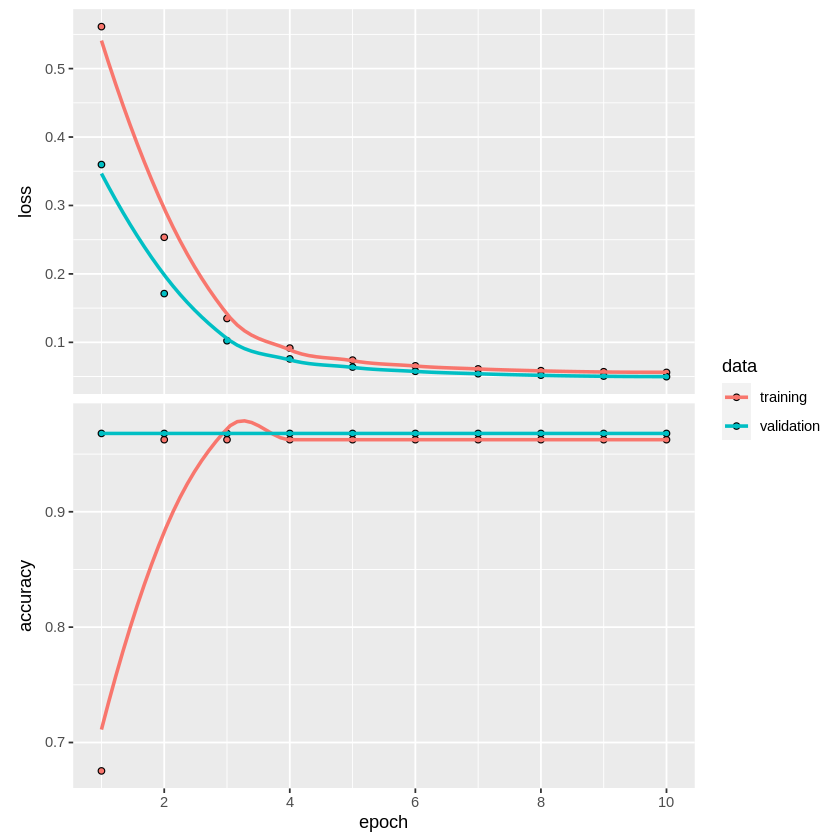

In [290]:
# epoch 10
fitModel_10 =
  model %>%
  fit(train_DL,
      target_train_DL,
      epochs = 10,
      batch_size = 20,
      validation_split = 0.30)

# plot fitmodel
plot(fitModel_10)

# kita ubah dulu data test_clean menjadi matrix
test_DL = test_clean %>% as.matrix()
target_test_DL = test_target %>% as.factor() %>% as.numeric() %>% to_categorical()

# prediksi dari data test
pred = model %>% predict(test_DL) %>% `>` (0.5) 
pred = ifelse(pred == T,1,0)

# tahapan membuat confusion matrix
level = test_target %>% as.factor() %>% levels()
df = target_test_DL[1:2000,2:7] %>% as.data.frame() 
colnames(df) = level
df_pred = pred[1:2000,2:7] %>% as.data.frame()
colnames(df_pred) = level
df$id = 1:2000
df_pred$id = 1:2000
df = 
  df %>%
  pivot_longer(cols = -id, names_to = "failure_type") %>% filter(value != 0) %>% select(-value)
df_pred = 
  df_pred %>%
  pivot_longer(cols = -id, names_to = "failure_type") %>% filter(value != 0) %>% select(-value)

# confusion matrix
table(df$failure_type,df_pred$failure_type)

# akurasi saat epoch = 10
akurasi = mean(df$failure_type == df_pred$failure_type)
print(paste0("Akurasi = ",akurasi))

## Epoch = 20

Berikut adalah hasil perhitungan untuk epoch = 20

Model: "sequential_21"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_73 (Dense)                   (None, 4)                       40          
                                                                                
 dense_72 (Dense)                   (None, 5)                       25          
                                                                                
 dense_71 (Dense)                   (None, 7)                       42          
                                                                                
Total params: 107
Trainable params: 107
Non-trainable params: 0
________________________________________________________________________________


`geom_smooth()` using formula 'y ~ x'



                          
                           No Failure
  Heat Dissipation Failure         27
  No Failure                     1939
  Overstrain Failure                9
  Power Failure                    15
  Random Failures                   5
  Tool Wear Failure                 5

[1] "Akurasi = 0.9695"


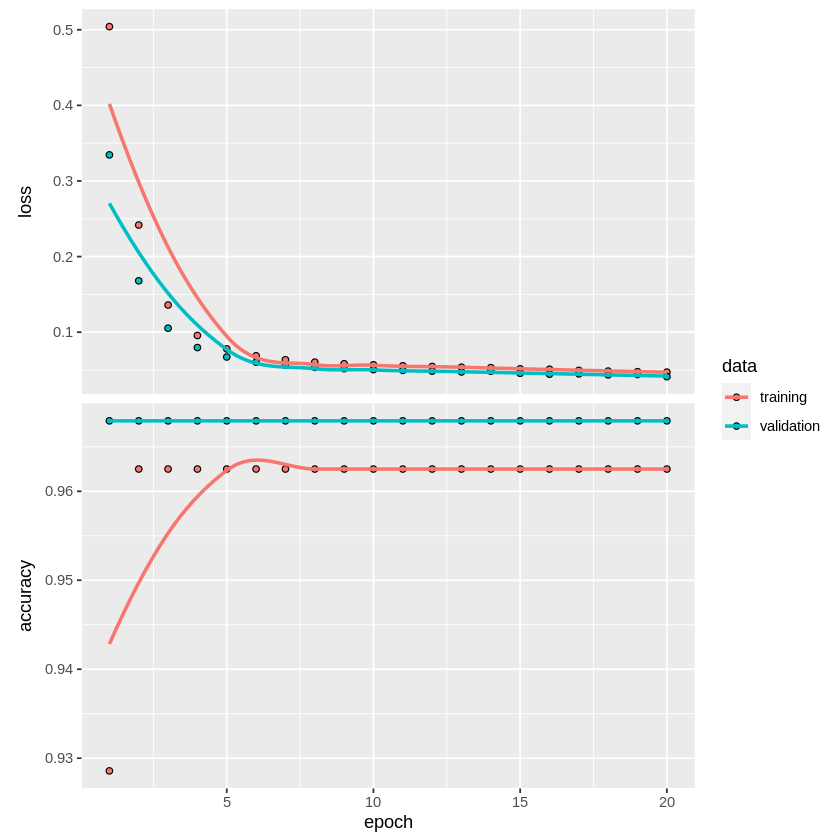

In [291]:
# membuat model deep learning
model = keras_model_sequential()
model %>%
  layer_dense(units = 4,activation = 'sigmoid',input_shape = c(ncol(train_DL))) %>%
  layer_dense(units = 5, activation = 'sigmoid') %>%
  layer_dense(units = 7, activation = 'sigmoid')
summary(model)

# compile
model %>% compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=c('accuracy')
)

# epoch 20
fitModel_20 =
  model %>%
  fit(train_DL,
      target_train_DL,
      epochs = 20,
      batch_size = 20,
      validation_split = 0.30)

# plot fitmodel
plot(fitModel_20)

# kita ubah dulu data test_clean menjadi matrix
test_DL = test_clean %>% as.matrix()
target_test_DL = test_target %>% as.factor() %>% as.numeric() %>% to_categorical()

# prediksi dari data test
pred = model %>% predict(test_DL) %>% `>` (0.5) 
pred = ifelse(pred == T,1,0)

# tahapan membuat confusion matrix
level = test_target %>% as.factor() %>% levels()
df = target_test_DL[1:2000,2:7] %>% as.data.frame() 
colnames(df) = level
df_pred = pred[1:2000,2:7] %>% as.data.frame()
colnames(df_pred) = level
df$id = 1:2000
df_pred$id = 1:2000
df = 
  df %>%
  pivot_longer(cols = -id, names_to = "failure_type") %>% filter(value != 0) %>% select(-value)
df_pred = 
  df_pred %>%
  pivot_longer(cols = -id, names_to = "failure_type") %>% filter(value != 0) %>% select(-value)

# confusion matrix
table(df$failure_type,df_pred$failure_type)

# akurasi saat epoch = 20
akurasi = mean(df$failure_type == df_pred$failure_type)
print(paste0("Akurasi = ",akurasi))

## Epoch = 30

Berikut adalah hasil perhitungan untuk epoch = 30

Model: "sequential_22"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_76 (Dense)                   (None, 4)                       40          
                                                                                
 dense_75 (Dense)                   (None, 5)                       25          
                                                                                
 dense_74 (Dense)                   (None, 7)                       42          
                                                                                
Total params: 107
Trainable params: 107
Non-trainable params: 0
________________________________________________________________________________


`geom_smooth()` using formula 'y ~ x'



                          
                           No Failure
  Heat Dissipation Failure         27
  No Failure                     1939
  Overstrain Failure                9
  Power Failure                    15
  Random Failures                   5
  Tool Wear Failure                 5

[1] "Akurasi = 0.9695"


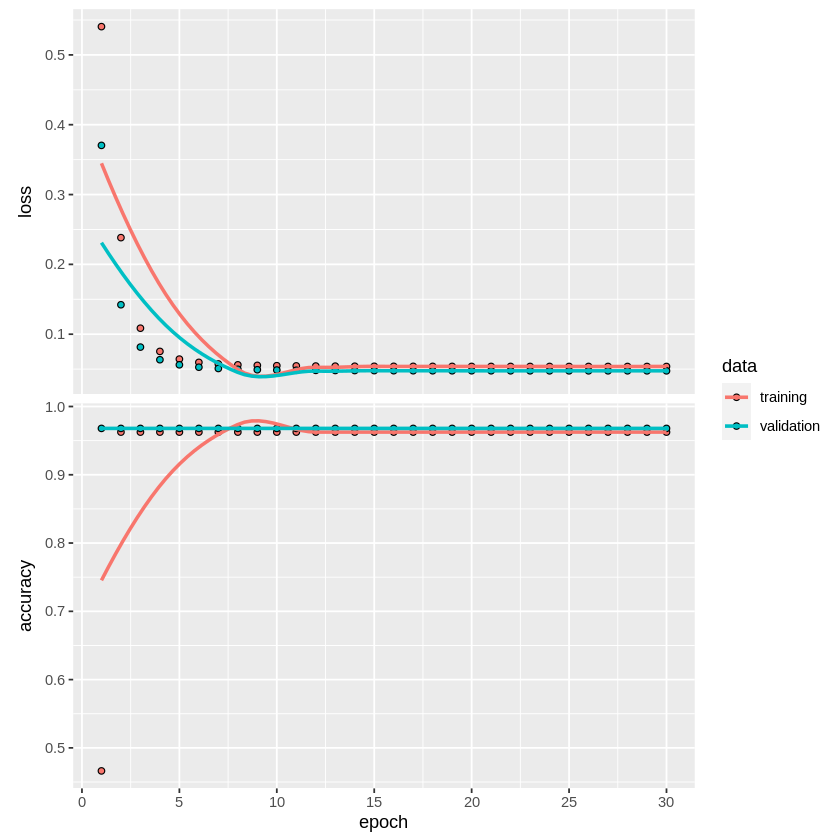

In [292]:
# membuat model deep learning
model = keras_model_sequential()
model %>%
  layer_dense(units = 4,activation = 'sigmoid',input_shape = c(ncol(train_DL))) %>%
  layer_dense(units = 5, activation = 'sigmoid') %>%
  layer_dense(units = 7, activation = 'sigmoid')
summary(model)

# compile
model %>% compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=c('accuracy')
)

# epoch 30
fitModel_30 =
  model %>%
  fit(train_DL,
      target_train_DL,
      epochs = 30,
      batch_size = 20,
      validation_split = 0.30)

# plot fitmodel
plot(fitModel_30)

# kita ubah dulu data test_clean menjadi matrix
test_DL = test_clean %>% as.matrix()
target_test_DL = test_target %>% as.factor() %>% as.numeric() %>% to_categorical()

# prediksi dari data test
pred = model %>% predict(test_DL) %>% `>` (0.5) 
pred = ifelse(pred == T,1,0)

# tahapan membuat confusion matrix
level = test_target %>% as.factor() %>% levels()
df = target_test_DL[1:2000,2:7] %>% as.data.frame() 
colnames(df) = level
df_pred = pred[1:2000,2:7] %>% as.data.frame()
colnames(df_pred) = level
df$id = 1:2000
df_pred$id = 1:2000
df = 
  df %>%
  pivot_longer(cols = -id, names_to = "failure_type") %>% filter(value != 0) %>% select(-value)
df_pred = 
  df_pred %>%
  pivot_longer(cols = -id, names_to = "failure_type") %>% filter(value != 0) %>% select(-value)

# confusion matrix
table(df$failure_type,df_pred$failure_type)

# akurasi saat epoch = 30
akurasi = mean(df$failure_type == df_pred$failure_type)
print(paste0("Akurasi = ",akurasi))

## Epoch = 40

Berikut adalah hasil perhitungan untuk epoch = 40

Model: "sequential_23"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_79 (Dense)                   (None, 4)                       40          
                                                                                
 dense_78 (Dense)                   (None, 5)                       25          
                                                                                
 dense_77 (Dense)                   (None, 7)                       42          
                                                                                
Total params: 107
Trainable params: 107
Non-trainable params: 0
________________________________________________________________________________


`geom_smooth()` using formula 'y ~ x'



                          
                           No Failure
  Heat Dissipation Failure         27
  No Failure                     1939
  Overstrain Failure                9
  Power Failure                    15
  Random Failures                   5
  Tool Wear Failure                 5

[1] "Akurasi = 0.9695"


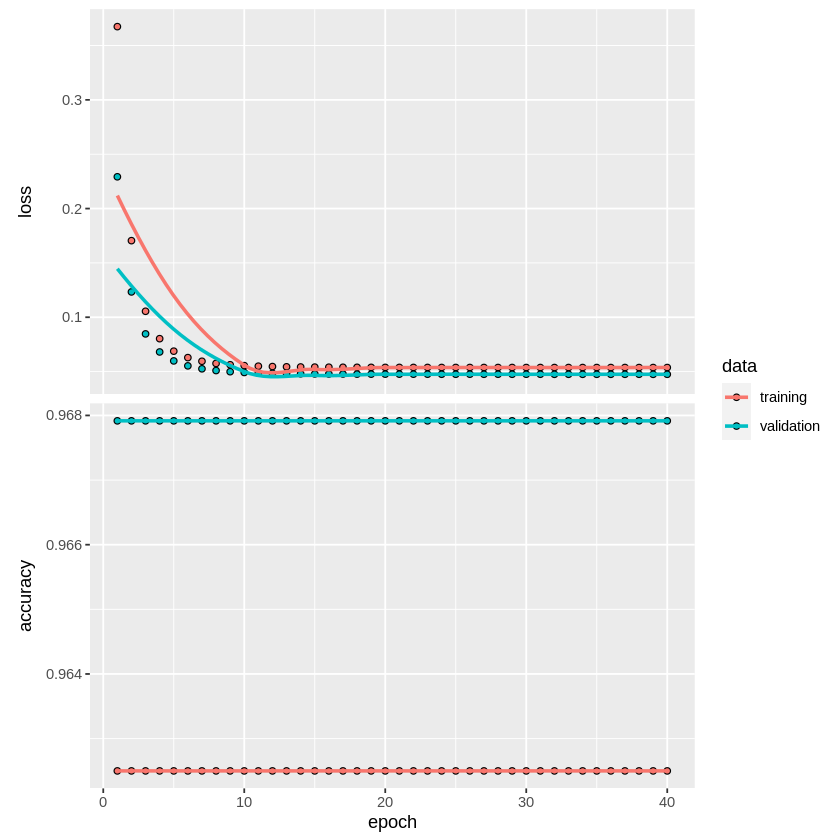

In [293]:
# membuat model deep learning
model = keras_model_sequential()
model %>%
  layer_dense(units = 4,activation = 'sigmoid',input_shape = c(ncol(train_DL))) %>%
  layer_dense(units = 5, activation = 'sigmoid') %>%
  layer_dense(units = 7, activation = 'sigmoid')
summary(model)

# compile
model %>% compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=c('accuracy')
)

# epoch 40
fitModel_40 =
  model %>%
  fit(train_DL,
      target_train_DL,
      epochs = 40,
      batch_size = 20,
      validation_split = 0.30)

# plot fitmodel
plot(fitModel_40)

# kita ubah dulu data test_clean menjadi matrix
test_DL = test_clean %>% as.matrix()
target_test_DL = test_target %>% as.factor() %>% as.numeric() %>% to_categorical()

# prediksi dari data test
pred = model %>% predict(test_DL) %>% `>` (0.5) 
pred = ifelse(pred == T,1,0)

# tahapan membuat confusion matrix
level = test_target %>% as.factor() %>% levels()
df = target_test_DL[1:2000,2:7] %>% as.data.frame() 
colnames(df) = level
df_pred = pred[1:2000,2:7] %>% as.data.frame()
colnames(df_pred) = level
df$id = 1:2000
df_pred$id = 1:2000
df = 
  df %>%
  pivot_longer(cols = -id, names_to = "failure_type") %>% filter(value != 0) %>% select(-value)
df_pred = 
  df_pred %>%
  pivot_longer(cols = -id, names_to = "failure_type") %>% filter(value != 0) %>% select(-value)

# confusion matrix
table(df$failure_type,df_pred$failure_type)

# akurasi saat epoch = 40
akurasi = mean(df$failure_type == df_pred$failure_type)
print(paste0("Akurasi = ",akurasi))

## Epoch = 50

Berikut adalah hasil perhitungan untuk epoch = 50

Model: "sequential_24"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_82 (Dense)                   (None, 4)                       40          
                                                                                
 dense_81 (Dense)                   (None, 5)                       25          
                                                                                
 dense_80 (Dense)                   (None, 7)                       42          
                                                                                
Total params: 107
Trainable params: 107
Non-trainable params: 0
________________________________________________________________________________


`geom_smooth()` using formula 'y ~ x'



                          
                           No Failure
  Heat Dissipation Failure         27
  No Failure                     1939
  Overstrain Failure                9
  Power Failure                    15
  Random Failures                   5
  Tool Wear Failure                 5

[1] "Akurasi = 0.9695"


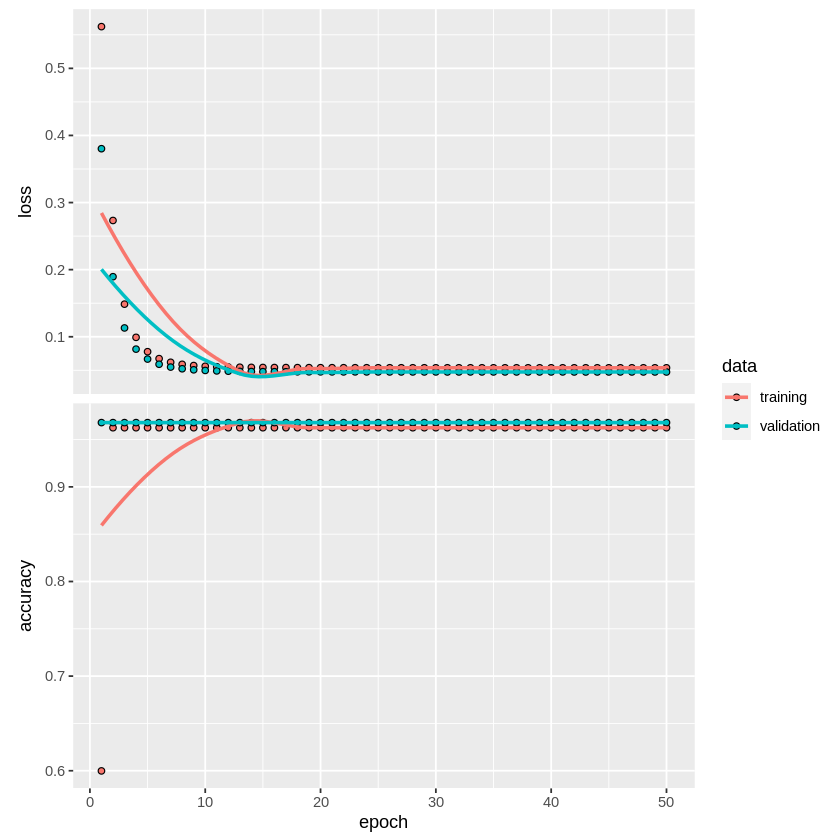

In [294]:
# membuat model deep learning
model = keras_model_sequential()
model %>%
  layer_dense(units = 4,activation = 'sigmoid',input_shape = c(ncol(train_DL))) %>%
  layer_dense(units = 5, activation = 'sigmoid') %>%
  layer_dense(units = 7, activation = 'sigmoid')
summary(model)

# compile
model %>% compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=c('accuracy')
)

# epoch 50
fitModel_50 =
  model %>%
  fit(train_DL,
      target_train_DL,
      epochs = 50,
      batch_size = 20,
      validation_split = 0.30)

# plot fitmodel
plot(fitModel_50)

# kita ubah dulu data test_clean menjadi matrix
test_DL = test_clean %>% as.matrix()
target_test_DL = test_target %>% as.factor() %>% as.numeric() %>% to_categorical()

# prediksi dari data test
pred = model %>% predict(test_DL) %>% `>` (0.5) 
pred = ifelse(pred == T,1,0)

# tahapan membuat confusion matrix
level = test_target %>% as.factor() %>% levels()
df = target_test_DL[1:2000,2:7] %>% as.data.frame() 
colnames(df) = level
df_pred = pred[1:2000,2:7] %>% as.data.frame()
colnames(df_pred) = level
df$id = 1:2000
df_pred$id = 1:2000
df = 
  df %>%
  pivot_longer(cols = -id, names_to = "failure_type") %>% filter(value != 0) %>% select(-value)
df_pred = 
  df_pred %>%
  pivot_longer(cols = -id, names_to = "failure_type") %>% filter(value != 0) %>% select(-value)

# confusion matrix
table(df$failure_type,df_pred$failure_type)

# akurasi saat epoch = 50
akurasi = mean(df$failure_type == df_pred$failure_type)
print(paste0("Akurasi = ",akurasi))

## __Kesimpulan ANN__

Dapat dilihat bahwa peningkatan nilai _epoch_ tidak berpengaruh terhadap peningkatan akurasi. Pada epoch = 10, nilai akurasi yang didapatkan sudah cukup baik.

SAlah satu penyebabnya adalah _imbalance dataset_ pada _test_ dimana _class_ `No Failure` sangat besar sehingga hasil prediksi semua data _test_ adalah `No Failure`.

# ___SUMMARY___ __PRAKTIKUM__

Bagi saya pribadi, algoritma _Naive Bayes_ dan _Decision Tree_ secara intuitif lebih mudah dipahami karena berlandaskan peluang bersyarat (NB) dan pemilahan entropi (DT). 

Selain itu saya bisa menentukan atribut mana yang lebih penting dibandingkan atribut lainnya sebagai _predictors_.

Namun ANN bisa saja menawarkan hasil prediksi yang lebih baik jika kita bisa menemukan ramuan yang tepat dalam menentukan berapa banyak _hidden layers_ dan _nodes_ serta _activation function_ yang ada.